In [1]:
!pip install gensim
!pip install contractions
import contractions
import html
import pandas as pd
import numpy as np
import re
import torch
import torch.nn as nn
import random
import torch.nn.functional as F
from gensim.models import FastText
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
train_data = pd.read_csv('../misc/cnn_dailymail/train.csv')
val_data = pd.read_csv('../misc/cnn_dailymail/validation.csv')
test_data = pd.read_csv('../misc/cnn_dailymail/test.csv')
len(train_data)

287113

In [3]:
x = train_data['article']
y = train_data['highlights']

In [4]:
def clean(text):
    text = contractions.fix(text)
    text = html.unescape(text)
    text = str(text)
    text = text.lower()
    text = re.sub('[^a-zA-Z0-9]',' ',text) 
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)
    text = ' '.join(text.split())
    return text

In [5]:
cleaned_source = list(map(clean,x))
cleaned_summary = list(map(clean,y))

START_TOKEN = '<START>'
END_TOKEN = '<END>'

for i in range(len(cleaned_summary)):
    cleaned_summary[i] = START_TOKEN + " " + cleaned_summary[i] + " " + END_TOKEN

In [6]:
new_source = []
new_summary = []

max_source_length = 300
max_summary_length = 100

for i in range(len(cleaned_source)):
    if len(cleaned_source[i].split()) <= max_source_length and len(cleaned_summary[i].split()) <= max_summary_length :
        new_source.append(cleaned_source[i])
        new_summary.append(cleaned_summary[i])

print(len(new_source))
print(len(new_summary))

24409
24409


In [8]:
#from gensim.models import FastText

#sentences = new_source + new_summary
#sent_ted = [] #all the words
#for sent in sentences:
#    sent_ted_child = sent.split()
#    sent_ted.append(sent_ted_child)

#print(sent_ted[0])

#model_ted = FastText(sent_ted, vector_size=128, window=3, min_count=1, workers=4,sg=1, epochs=1500)

#import pickle
#pickle.dump(model_ted, open('128_emb_inshorts.pkl', 'wb'))

In [7]:
import pickle
model_ted = pickle.load(open('./128_emb_cnn_300_100.pkl', 'rb'))
weights = model_ted.wv #weight vectors representing all the words
print(model_ted.wv.most_similar("milk"))

[('dairy', 0.6152066588401794), ('breast', 0.554631233215332), ('food', 0.5541932582855225), ('lactose', 0.5267015695571899), ('mooo', 0.5247284770011902), ('alcoholic', 0.5210902690887451), ('70g', 0.5209250450134277), ('cream', 0.5195273160934448), ('gallons', 0.5182810425758362), ('aizu', 0.5173525214195251)]


In [8]:
from collections import OrderedDict 

word2Index_enc = {} #encoder word-2-index
word2Index_dec = {} #decoder word-2-index

ind2Word_enc = {} #reverse dictionaries for the above
ind2Word_dec = {}

encoder_paragraph = list(set((' '.join(new_source)).split()))

decoder_paragraph_list = list((' '.join(new_summary)).split())
decoder_dict = OrderedDict()

for word in decoder_paragraph_list: #make a freq_dict of decoder words
    try:
        decoder_dict[word] = decoder_dict[word] + 1
    except:
        decoder_dict[word] = 1

ind2Word_enc[0] = START_TOKEN
ind2Word_dec[0] = START_TOKEN
word2Index_enc[START_TOKEN] = 0
word2Index_dec[START_TOKEN] = 0
ind2Word_enc[1] = END_TOKEN
ind2Word_dec[1] = END_TOKEN
word2Index_enc[END_TOKEN] = 1
word2Index_dec[END_TOKEN] = 1

dec_index = 1
for (decoder_dict_word, decoder_dict_number) in decoder_dict.items():
    word2Index_dec[decoder_dict_word] = dec_index
    ind2Word_dec[dec_index] = decoder_dict_word
    dec_index+=1

enc_index = 1
for index,word in enumerate(encoder_paragraph):
    if word != ' ':
        word2Index_enc[word] = enc_index
        ind2Word_enc[enc_index] = word 
        enc_index+=1

In [9]:
encoder_input = [[word2Index_enc[word] for word in sentence.split() if word in word2Index_enc.keys()] for sentence in new_source ]
decoder_input = [[word2Index_dec[word] for word in sentence.split() if word in word2Index_dec.keys()] for sentence in new_summary ]

In [10]:
encoder_tensor = [torch.tensor(li ,dtype=torch.long,device=device).view(-1, 1) for li in encoder_input]
decoder_tensor = [torch.tensor(li,dtype=torch.long,device=device).view(-1, 1) for li in decoder_input]

In [11]:
class Encoder(nn.Module):
    def __init__(self, input_vocab_size, hidden_size, num_layers=1, bidirectional=False):
        super(Encoder,self).__init__()
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.input_vocab_size = input_vocab_size
        self.gru_layer = nn.GRU(input_size = self.hidden_size,
                                hidden_size = self.hidden_size,
                                num_layers = self.num_layers,
                               bidirectional = self.bidirectional)
    

    def forward(self, input_, prev_hidden_state):
        #get the input word from the index
        input_word = ind2Word_enc[input_.data.tolist()[0]] 
        
        #get the weights (vector encoding of that word) from the FastText encoding
        embedded_outputs = torch.tensor(weights[input_word], device = device).view(1,1,-1) 
        
        #input has to be (seq_length, batch_size, input_size)
        #output will be (seq_length, batch_size, D * hidden_size)
        output,prev_hidden_state = self.gru_layer(embedded_outputs, prev_hidden_state)  
        hidden = prev_hidden_state
        return output, hidden

    def init_hidden(self, batch_size):
        #hidden has to be ((D * num_layers), batch_size, hidden_size)
        return torch.zeros(self.num_directions * self.num_layers,batch_size,self.hidden_size,device=device)

In [23]:
class AttentionDecoder(nn.Module):
    def __init__(self, output_vocab_size, hidden_size, max_length_encoder, dropout_value, num_layers=1):
        super(AttentionDecoder,self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_vocab_size = output_vocab_size
        self.dropout_p = dropout_value
        self.max_length_encoder = max_length_encoder
        self.embedding_layer = nn.Embedding(self.output_vocab_size, self.hidden_size)
        self.attention_layer = nn.Linear(self.hidden_size*2, self.max_length_encoder)
        self.attention_combine = nn.Linear(self.hidden_size*3, self.hidden_size)

        self.gru_layer = nn.GRU(self.hidden_size, self.hidden_size)
        self.output_layer = nn.Linear(self.hidden_size, self.output_vocab_size)
        self.dropout_layer = nn.Dropout(self.dropout_p)

    def forward(self, input_, prev_hidden_state, encoder_output):
        input_word = ind2Word_dec[input_.data.tolist()[0]]
        embedded_outputs = torch.tensor(weights[input_word], device = device).view(1,1,-1)
        
        embeddings_dropout = self.dropout_layer(embedded_outputs)
        #calculate attention layer
        attention_layer_output = self.attention_layer(torch.cat((embeddings_dropout[0], prev_hidden_state[0]), 1))
        #calculate alphas with softmax
        attention_weights = nn.functional.softmax(attention_layer_output, dim=1)
        #multiply them with encoder output to get context vector
        attention_applied = torch.bmm(attention_weights.unsqueeze(0), encoder_output.unsqueeze(0))
        #run it through a linear layer to get logits
        attention_combine_logits = self.attention_combine(torch.cat((embeddings_dropout[0], attention_applied[0]), 1)).unsqueeze(0) #since gru requires a batch dimension 
        #put that through relu
        attention_combine_relu = nn.functional.relu(attention_combine_logits)

        hidden = prev_hidden_state[-1, :, :].unsqueeze(0) #only using the last hidden state
        output,hidden = self.gru_layer(attention_combine_relu, hidden)
        output_logits = self.output_layer(output)
        output_softmax = nn.functional.log_softmax(output_logits[0], dim=1)
        return output_softmax, hidden, attention_weights

In [30]:
teacher_forcing_ratio = 0.5
batch_size = 1

def train(encoder, 
          decoder, 
          input_tensor, 
          target_tensor, 
          encoder_optimizer, 
          decoder_optimizer, 
          criterion, 
          max_length, 
          iters):

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    encoder_hidden = encoder.init_hidden(batch_size) 
    #because it's bidirectional
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size * 2, device = device)

    input_length = input_tensor.size(0) #number of words in the input
    output_length = target_tensor.size(0) #in the output

    loss = 0


    for encoder_index in range(0, input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[encoder_index], encoder_hidden)
        encoder_outputs[encoder_index] = encoder_output[0,0] #keep saving the encoder output

    #start the decoder with the start of sentence token
    decoder_input = torch.tensor([word2Index_dec[START_TOKEN]],device=device)   
    #pass it the encoder hidden as context vector
    decoder_hidden = encoder_hidden
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    if use_teacher_forcing:
        for decoder_index in range(output_length):
            decoder_output, decoder_hidden, decoder_attentions = \
            decoder(decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[decoder_index])
            decoder_input = target_tensor[decoder_index]
    else:
        for decoder_index in range(output_length):
            decoder_output, decoder_hidden, decoder_attentions = \
            decoder(decoder_input, decoder_hidden, encoder_outputs) 
                
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze(1).detach() 
            
            loss += criterion(decoder_output, target_tensor[decoder_index])
            
            try:
                if decoder_input.item() == word2Index_dec[END_TOKEN]:
                    break
            except KeyError:
                continue
            
    loss.backward()
    
    #clip the gradient
    if iters % 20000 == 0:
        torch.nn.utils.clip_grad_norm_(encoder.parameters(), 0.4)
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), 0.4)

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item()/output_length

In [14]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    if percent != 0:
        es = s / (percent)
        rs = es - s
        return '%s (- %s)' % (asMinutes(s), asMinutes(rs))
    else:
        return 0

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [29]:
# Dictionary for creating loss graph
loss_graph = {}

def train_Iters(encoder, decoder, n_iters, print_every=50, plot_every=100,learning_rate = 0.03):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0

    encoder_optimizer = torch.optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = torch.optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [random.choice(pairs) for i in range(n_iters)]
  
    criterion = nn.NLLLoss()
    for iters in range(n_iters):
        training_pair = training_pairs[iters - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        input_tensor = torch.tensor(input_tensor, dtype=torch.long, device = device).view(-1, 1)
        target_tensor = torch.tensor(target_tensor, dtype=torch.long, device = device).view(-1, 1)

        loss = train(encoder, decoder, input_tensor, target_tensor,
                     encoder_optimizer, decoder_optimizer, criterion,
                     max_source_length, iters)
        print_loss_total += loss
        plot_loss_total += loss

        if iters % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            progress = iters / n_iters
            print('%s (%s %d%%) %.4f' % (timeSince(start, progress), iters, progress * 100, print_loss_avg))

            if iters > 0:
                loss_graph[iters] = print_loss_avg

        if iters % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)
  

In [17]:
pairs = []
for enc,dec in zip(encoder_input,decoder_input):
    pairs.append([enc,dec])

In [31]:
hidden_size = 128
rnn_encoder = Encoder(len(word2Index_enc.keys()), hidden_size, num_layers = 4, bidirectional = True).to(device = device)
rnn_decoder = AttentionDecoder(len(word2Index_dec.keys()), hidden_size, max_source_length, 0.2).to(device = device)

In [32]:
train_Iters(rnn_encoder, rnn_decoder, 30000)

0 (0 0%) 0.2130
0m 23s (- 234m 21s) (50 0%) 11.7906
0m 47s (- 235m 13s) (100 0%) 20.4521
1m 11s (- 235m 31s) (150 0%) 21.9541
1m 32s (- 230m 15s) (200 0%) 21.0891
1m 57s (- 233m 41s) (250 0%) 20.0879
2m 20s (- 232m 32s) (300 1%) 20.9396
2m 43s (- 231m 1s) (350 1%) 26.7564
3m 7s (- 231m 10s) (400 1%) 24.0128
3m 29s (- 228m 52s) (450 1%) 24.0521
3m 53s (- 229m 8s) (500 1%) 28.0386
4m 15s (- 228m 19s) (550 1%) 31.5611
4m 39s (- 227m 54s) (600 2%) 25.0885
5m 0s (- 226m 26s) (650 2%) 29.5116
5m 24s (- 226m 8s) (700 2%) 29.6635
5m 46s (- 225m 26s) (750 2%) 29.3064
6m 10s (- 225m 14s) (800 2%) 24.0360
6m 34s (- 225m 19s) (850 2%) 24.6174
6m 57s (- 224m 57s) (900 3%) 23.2018
7m 22s (- 225m 17s) (950 3%) 30.0088
7m 44s (- 224m 32s) (1000 3%) 27.1985
8m 8s (- 224m 35s) (1050 3%) 32.4024
8m 31s (- 223m 50s) (1100 3%) 26.7417
8m 53s (- 223m 13s) (1150 3%) 26.5710
9m 16s (- 222m 41s) (1200 4%) 27.0421
9m 40s (- 222m 26s) (1250 4%) 31.3199
10m 5s (- 222m 58s) (1300 4%) 29.1404
10m 29s (- 222m 48s) (

In [30]:
encoder_path = './cnn_enc_attention.w'
decoder_path = './cnn_decoder_attention.w'
torch.save(rnn_encoder.state_dict(), encoder_path)
torch.save(rnn_decoder.state_dict(), decoder_path)

#rnn_encoder.load_state_dict(torch.load(encoder_path))
#rnn_encoder.eval()
#rnn_decoder.load_state_dict(torch.load(decoder_path))
#rnn_decoder.eval()

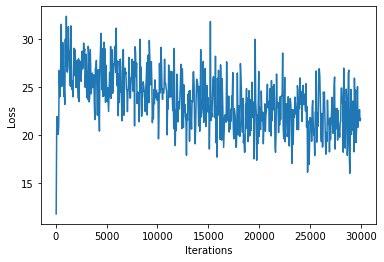

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt

iters = list(loss_graph.keys())
loss_val = list(loss_graph.values())
plt.plot(iters, loss_val) 
plt.xlabel('Iterations') 
plt.ylabel('Loss')  
plt.show()

In [35]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        pair1 = torch.tensor(pair[0],dtype=torch.long,device=device)
        pair2 = pair[1]
        output_words, attentions = evaluate(encoder, decoder, pair1)
        output_sentence = ' '.join(output_words)
        output_list = [ind2Word_dec[word] for word in pair2]
        output_list = ' '.join(output_list)
        input_sentence = [ind2Word_enc[element.item()] for element in pair1.flatten()]
        input_sentence = ' '.join(input_sentence)
        print("Article = ",input_sentence)
        print('\n Predicted Summary = ', output_sentence)
        print('\n Reference Summary =', output_list)

In [44]:
def evaluate(encoder, decoder, encoder_tensor, max_length = max_source_length):
    with torch.no_grad():
        input_tensor = encoder_tensor
        input_length = input_tensor.size(0)
        encoder_hidden = encoder.init_hidden(batch_size)

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size * 2, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei].unsqueeze(0),
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([word2Index_dec[START_TOKEN]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)
        
        for di in range(max_summary_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if ind2Word_dec[topi.item()] == END_TOKEN:
                decoded_words.append(END_TOKEN)
                break
            else:
                decoded_words.append(ind2Word_dec[topi.item()])

            decoder_input = topi.squeeze(1).detach()

        return decoded_words, decoder_attentions[:di + 1]

In [45]:
evaluateRandomly(rnn_encoder, rnn_decoder)

Article =  despite their inconsistent start to the season and an injury crisis that has left their squad bereft of some world class talent manchester united s players appear to be in good spirits ahead of their clash against arsenal on saturday david de gea was a doubt for the match after dislocating his finger on international duty with spain but trained with the squad and was all smiles in ander herrera s upload via instagram luke shaw angel di maria and michael carrick also trained in the week in what is undoubtedly a massive boost for manager louis van gaal video scroll down for sportsmail s premier league preview arsenal vs manchester united ander herrera right uploaded the above image via instagram with his manchester united team mates david de gea left and angel di maria pose for a selfie ahead of their clash against arsenal radamel falcao right has endured a difficult start to his career in a manchester united shirt angel di maria celebrates scoring for manchester united in the

In [39]:
!pip install tqdm
from tqdm import tqdm

In [40]:
def evaluateForRouge(encoder, decoder, n=10):
    preds = []
    references = []
    for i in tqdm(range(len(pairs_test))):
        pair = pairs_test[i]
        pair1 = torch.tensor(pair[0],dtype=torch.long,device=device)
        pair2 = pair[1]
        output_words, attentions = evaluate(encoder, decoder, pair1)
        output_sentence = ' '.join(output_words)
        output_list = [ind2Word_dec[word] for word in pair2]
        output_list = ' '.join(output_list)
        preds.append(output_sentence)
        references.append(output_list)
    return preds, references

In [41]:
!pip install evaluate
import evaluate as hf_evaluate

rouge_score = hf_evaluate.load("rouge")

In [55]:
x_test = test_data['article']
y_test = test_data['highlights']

cleaned_source_test = list(map(clean,x_test))
cleaned_summary_test = list(map(clean,y_test))

for i in range(len(cleaned_summary_test)):
    cleaned_summary_test[i] = START_TOKEN + " " + cleaned_summary_test[i] + " " + END_TOKEN

max_source_length = 300
max_summary_length = 100
    
new_source_test = []
new_summary_test = []

for i in range(len(cleaned_source_test)):
    if len(cleaned_source_test[i].split()) <= max_source_length and len(cleaned_summary_test[i].split()) <= max_summary_length :
        new_source_test.append(cleaned_source_test[i])
        new_summary_test.append(cleaned_summary_test[i])
    
encoder_input_test = [[word2Index_enc[word] for word in sentence.split() if word in word2Index_enc.keys()] for sentence in new_source_test ]
decoder_input_test = [[word2Index_dec[word] for word in sentence.split() if word in word2Index_dec.keys()] for sentence in new_summary_test ]
    

pairs_test = []
for enc,dec in zip(encoder_input_test,decoder_input_test):
    pairs_test.append([enc,dec])

In [59]:
preds, references = evaluateForRouge(rnn_encoder, rnn_decoder)

100%|██████████| 1129/1129 [03:20<00:00,  5.64it/s]


In [60]:
scores = rouge_score.compute(
    predictions=preds, references=references
)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, round(scores[rn] * 100, 2)) for rn in rouge_names)
rouge_dict

{'rouge1': 14.21, 'rouge2': 0.65, 'rougeL': 12.9, 'rougeLsum': 12.91}